# H02
> 本文所使用的是 [Julia](https://julialang.org/), 以及所涉及的包
> - [`Plots`](https://docs.juliaplots.org/stable/)
> - [`LaTeXStrings`](https://github.com/JuliaStrings/LaTeXStrings.jl)

## 一般复制子动力学方程
- 根据复制子动力方程的矩阵一般形式
    $$\dot{x}_{i} = x_{i}[(A\boldsymbol{x})_{i} - \boldsymbol{x}^{\mathrm{T}}A\boldsymbol{x}] \tag{1} $$
    - $x_{i}$ 表示使用策略 $s_{i}$ 的人数占总人数的比例
    - $\boldsymbol{x}$ 表示人口状态，其为由使用各策略人数占总人数的比例 $x_{i}$ 组成，即 $\boldsymbol{x} = (x_{1},x_{2},\cdots,x_{n})$ 对应策略集 $\boldsymbol{S} = \{ s_{1},s_{2},\dots,s_{n} \}$。于是有 $\left\{ \boldsymbol{x} \in \mathbb{R}^{n} : \sum_{i=1}^{n}x_{i} = 1  \text{ and } x_{i}\geq 0 \text{ for } i =1,2,\dots,n\right\}$ 
    - $A$ 为局中人I所对应的支付矩阵
- 在二维条件下加入约束
  $$ \boldsymbol{x} = (x, 1-x) $$
	- $x$ 表示使用策略 $s_{1}$ 的人数占总人数的比例。结合式 $(1)$ 可得
	  $$ \dot{x} = x\left[\left(A\begin{pmatrix}x \\1-x\end{pmatrix}\right)_{1} - \begin{pmatrix}x & 1-x\end{pmatrix}A\begin{pmatrix}x \\ 1-x\end{pmatrix}\right] $$
- 在模拟中，将上述的微分方程变为差分方程
  $$ x(n+1) = x(n) + \dot{x}\cdot \Delta t $$
- 于是构造出描述 $x$ 的函数 `replicator_dynamics()`，包含三个参数
  - `𝐀`：支付矩阵
  - `x`：初始时，使用策略 $s_{1}$ 的人数占整体的百分比
  - `step_range`：迭代次数，即经过 `step_range` 次随机博弈
  - `Δt`：代表个体对于博弈结果的**易感程度**，即受博弈结果影响而改变策略的程度。


In [1]:
function replicator_dynamics(𝐀::Matrix, x::Float64, step_range::Int, Δt::Float64)::Vector{Float64}
	# 𝐀 is the payoff matrix
	# x is the initial percentage of hard-working people in the total
	# step_range is the number of iterations
	# Δt denote individual's susceptibility to the outcome of a game

	
	# This function convert the x (percentage of hard-working people) to the state of population X
    X(x) = [x, 1-x]; 

	# This function calculate the velocity of x (percentage of hard-working people)
	ẋ(x) = (x * ((𝐀 * X(x))[1] - X(x)' * 𝐀 * X(x)))[1]

	# Convert the differential equation to difference equation
	Δx(x) = Δt * ẋ(x)
	
	𝐱 = [x];

	for i in 1:step_range
		𝐱 = push!(𝐱, 𝐱[i] + Δx(𝐱[i]))
	end
	return 𝐱
end

replicator_dynamics (generic function with 1 method)

## 对于作业博弈模型
### 初步分析
- **场景**：$100$ 名同学。一学期布置 $16$ 次作业，每次作业同学都以 $2$ 人为一组为单位来完成作业。每次老师都会将全班同学重新**随机**分为 $2$ 人一组的 $50$ 组。
- 其支付矩阵如下，这是一种对称博弈
  
  |             | 全力以赴($s_{1}$) | 偷工减料($s_{2}$) |
  | ----------- | ----------- | ----------- |
  | 全力以赴($s_{1}$) | $4,4$       | $1,5$       |
  | 偷工减料($s_{2}$) | $5,1$       | $2,2$       | 
	- 单纯从博弈论角度：明显可见 $A =  \begin{bmatrix}4  & 1 \\ 5 & 2\end{bmatrix}$，即 $s_{2}$ “偷工减料”为占优纯策略，即对于个体而言，必然会选择“偷工减料”的策略。
- 其符合复制子动态方程的前提假设
	- 随机个体之间进行二人对称博弈
	- 所有个体的支付矩阵是一定的
	- 总体数量到达一定量级

### 数值模拟
- 由初步分析可知，所需的三个参数
  - `𝐀 = [4 1; 5 2]`
  - `step_range = 16`
  - `x` 可以自定义

#### 对于 $x$ 不同初始值的模拟
- 如下 Code 对于不同的 $x$ 初始值 `x₀` 进行了模拟


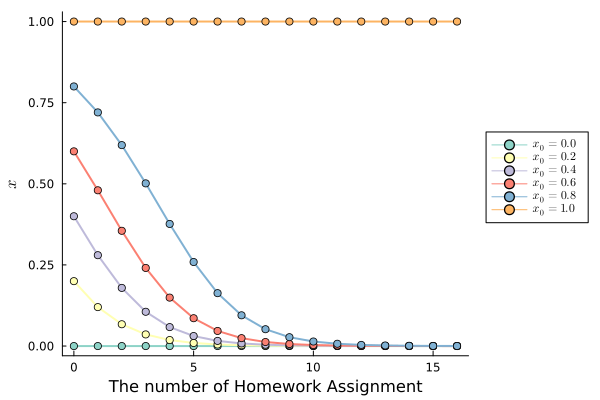

In [2]:
using Plots, LaTeXStrings

# Define the parameter of replicator_dynamics()
T = 16;
A = [4 1; 5 2];
t = [0:T...];
x₀_v = [0:0.2:1...];    # Using a Vector to compare result under different initial percentage
Δt = 0.5;

# Calculate the simulation result under different initial percentage
sim_in_different_x₀ = [replicator_dynamics(A, i, T, Δt) for i in x₀_v];

# Plot a graph between the number of Homework Assignment and x
default()
default(
    grid = false,
	legend = :outerright,
	palette = :Set3_9,
	lw = 2,
	xlabel = "The number of Homework Assignment",
	ylabel = L"x")
fig = plot()
for i in 1:size(sim_in_different_x₀)[1]
	plot!(t, sim_in_different_x₀[i], c = i, label = latexstring("x_{0}=$(x₀_v[i])"), m = :circle)
end

plot(fig)


In [3]:
# savefig(fig, "/home/zpp/Picture/RD_02.svg")

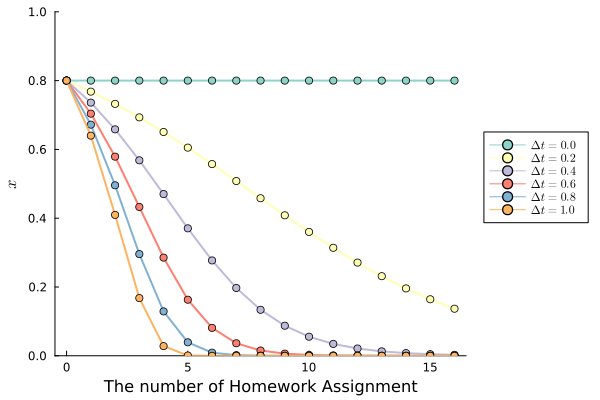

In [4]:
using Plots, LaTeXStrings

# Define the parameter of replicator_dynamics()
T = 16;
A = [4 1; 5 2];
t = [0:T...];
x₀ = 0.8;    
Δ𝐭 = [0:0.2:1...]; # Using a Vector to compare result under different susceptibility

# Calculate the simulation result under different initial percentage
sim_in_different_x₀ = [replicator_dynamics(A, x₀, T, i) for i in Δ𝐭];

# Plot a graph between the number of Homework Assignment and x
default()
default(
	grid = false,
	legend = :outerright,
	palette = :Set3_9,
	lw = 2,
	xlabel = "The number of Homework Assignment",
	ylabel = L"x",
	ylims = [0, 1])
fig1 = plot()
for i in 1:size(sim_in_different_x₀)[1]
	plot!(t, sim_in_different_x₀[i], c = i, label = L"\Delta t=" * latexstring("$(Δ𝐭[i])"), m = :circle)
end

plot(fig1)

In [5]:
# savefig(fig1, "/home/zpp/Picture/RD_03.svg")

# Appendix
- 相图

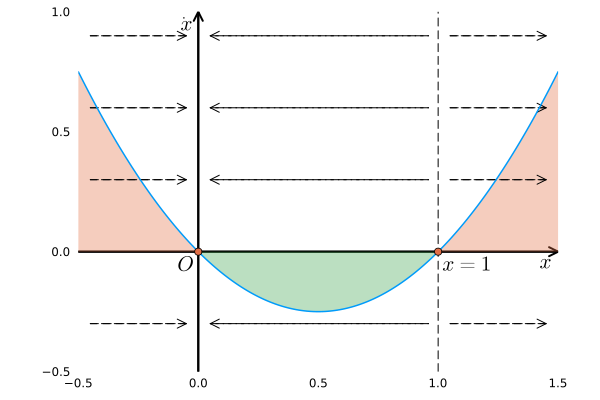

In [6]:
using Plots, LaTeXStrings

default()
default(
	grid = false,
	axis = false,
	label = "",
	ylims = [-0.5, 1],
	xlims = [-0.5, 1.5],
	aspect_ratio = :equal,
	lw = 1.5,
	# size = (500, 375)
)


x = collect(-0.5:0.01:1.5);
f(x) = -1 * x * (1 - x);

fig2 = plot([-0.5, 1.5], [0, 0], c = :black, arrow = true, lw = 2)
plot!([0, 0], [-1, 1], c = :black, arrow = true, lw = 2)
plot!(
	x[findall(x -> x < 0, x)],
	f.(x[findall(x -> x < 0, x)]),
	lw = 0,
	fillrange = 0,
	fillalpha = 0.35,
	c = 2)
plot!(
	x[findall(x -> x >= 1, x)],
	f.(x[findall(x -> x >= 1, x)]),
	lw = 0,
	fillrange = 0,
	fillalpha = 0.35,
	c = 2)
plot!(
	x[findall(x -> x <= 1 && x >= 0, x)],
	f.(x[findall(x -> x <= 1 && x >= 0, x)]),
	lw = 0,
	fillrange = 0,
	fillalpha = 0.35,
	c = 3)

for i in -0.9:0.3:0.9
	if i == 0
		continue
	end
	plot!([-0.45, -0.05], [i, i], arrow = true, c = :black, ls = :dash, lw = 1)
	plot!([0.96, 0.05], [i, i], arrow = true, c = :black, ls = :dash, lw = 1)
	plot!([1.05, 1.45], [i, i], arrow = true, c = :black, ls = :dash, lw = 1)
end
plot!(x, f.(x), c = 1)
vline!([1], c = :black, lw = 1, ls = :dash)
scatter!([0], [0], c = 2)
scatter!([1], [0], c = 2)
annotate!([-0.05], [0.95], L"\dot{x}")
annotate!([1.45], [-0.05], L"x")
annotate!([-0.05], [-0.05], L"O")
annotate!([1.02], [-0.05], (L"x=1", :left))

# savefig("")


In [7]:
# savefig(fig2, "/home/zpp/Picture/RD_01_new.svg")